# Emphysema / Lung cancer relationship
* analyze on VLSP and NLST datasets
* compute odds ratio 
* multivariate logistic regression to control for PLCO covariates

In [13]:
import pandas as pd
import numpy as np
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_colwidth', None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf

# NLST

In [2]:
nlst_cohort = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/nlst_cohort_prep_v2.csv"
sample = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/nlst_sample.csv"
nlst_emp = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/emp_nlst/emphysema_nlst_softkernel.csv"
cohort_df = pd.read_csv(nlst_cohort, dtype={'pid':str})
sample_df = pd.read_csv("/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/nlst_sample.csv", dtype={'pid':str})
emp_df = pd.read_csv(nlst_emp, dtype={'pid':str})

def parse_section(x):
    mapper={
        'Left': 'Left',
        'Right': 'Right',
        'All': 'Total',
        'Left upper': 'LUL',
        'Left lower': 'LLL',
        'Right upper': 'RUL',
        'Right lower': 'RLL',
        'Right middle': 'RML'
    }
    return mapper[x]
# emp['Section'] = emp['Section'].apply(lambda x: parse_section(x))
# emp = emp[emp['scanid'].str.contains('time')]
# emp['session'] = emp['scanid'].apply(lambda x: x.split('time')[1])
# emp['pid'] = emp['scanid'].apply(lambda x: x.split('time')[0])
emp = emp_df.rename({'scanid': 'series_uid'}, axis=1)
emp = emp.groupby(['series_uid', 'lobe'], as_index=False).min()
emp = emp.merge(sample_df[['pid', 'session', 'id', 'series_uid']], on='series_uid', how='left')
emp

,series_uid,lobe,lobe_vol,LAV,LAVp,residual_vol,residualp,pid,session,id
0,1.2.840.113654.2.55.100338961145591621256639291024735384711,All,4156.970849,119.038780,0.028636,4037.932069,0.971364,124312,0,124312time1999
1,1.2.840.113654.2.55.100338961145591621256639291024735384711,LLL,780.703511,10.962314,0.014042,769.741197,0.985958,124312,0,124312time1999
2,1.2.840.113654.2.55.100338961145591621256639291024735384711,LUL,1019.871123,12.881491,0.012631,1006.989631,0.987369,124312,0,124312time1999
3,1.2.840.113654.2.55.100338961145591621256639291024735384711,Left,1800.574633,23.843805,0.013242,1776.730828,0.986758,124312,0,124312time1999
4,1.2.840.113654.2.55.100338961145591621256639291024735384711,RLL,1053.229275,53.770441,0.051053,999.458834,0.948947,124312,0,124312time1999
...,...,...,...,...,...,...,...,...,...,...
10163,1.3.6.1.4.1.14519.5.2.1.7009.9004.979264092049396925265762967227,Left,3198.348424,231.197086,0.072286,2967.151338,0.927714,212869,0,212869time1999
10164,1.3.6.1.4.1.14519.5.2.1.7009.9004.979264092049396925265762967227,RLL,1770.325018,80.850050,0.045670,1689.474968,0.954330,212869,0,212869time1999
10165,1.3.6.1.4.1.14519.5.2.1.7009.9004.979264092049396925265762967227,RML,604.971940,29.231514,0.048319,575.740427,0.951681,212869,0,212869time1999
10166,1.3.6.1.4.1.14519.5.2.1.7009.9004.979264092049396925265762967227,RUL,1291.540602,61.358949,0.047508,1230.181653,0.952492,212869,0,212869time1999


In [3]:
# identitify worst emp cases
emp['LAVp'] = emp['LAVp'].astype(float)

# find interquartile range
from scipy.stats import iqr

emp.groupby('lobe', as_index=False)['LAVp'].agg(iqr)

,lobe,LAVp
0,All,NaN
1,LLL,NaN
2,LUL,NaN
3,Left,NaN
4,RLL,NaN
5,RML,NaN
6,RUL,NaN
7,Right,NaN


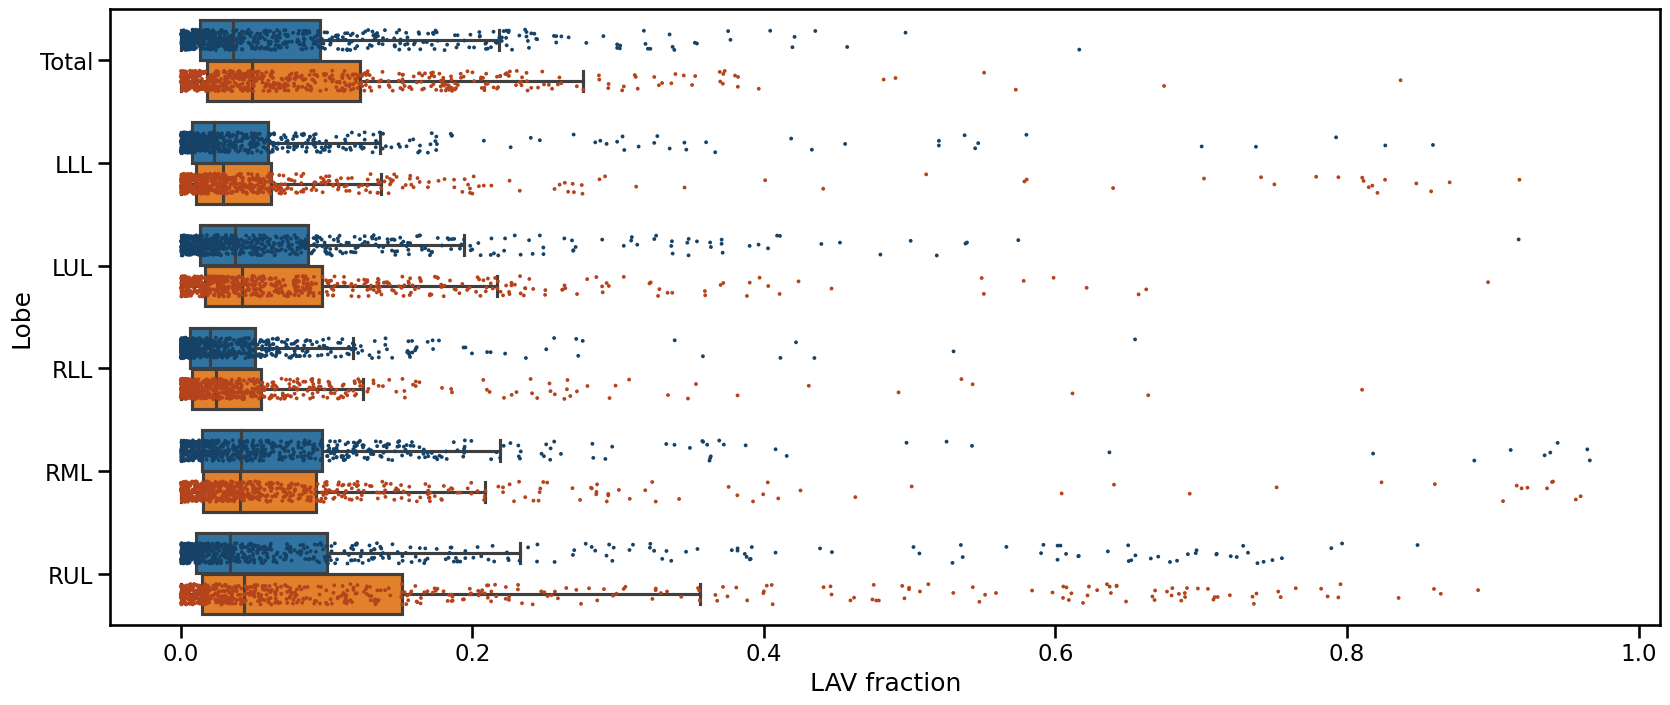

In [4]:
# visualize distributions of emphysema measures by lung cancer
cohort_grp = cohort_df.groupby('pid', as_index=False).max()
merged = cohort_grp.merge(emp, on='pid', how='inner')
merged['LAVp'] = merged['LAVp'].astype(float)
merged['lobe'] = merged['lobe'].apply(lambda x: 'Total' if x=='All' else x)

# Plot
sns.set_context(context='talk')
fig, ax = plt.subplots(figsize=(20,8))
merged = merged[~((merged['lobe']=='Left') | (merged['lobe']=='Right'))]
# sns.violinplot(x='LAVp', y='lobe', data = merged, hue='lung_cancer', split=True, showfliers=False, orient='h')
sns.boxplot(x='LAVp', y='lobe', data = merged, hue='lung_cancer', showfliers=False, orient='h')
sns.stripplot(x='LAVp', y='lobe', data=merged, hue='lung_cancer', jitter=0.2, dodge=True, size=2.75, alpha=1, orient='h', palette=["#154266","#b5431b"])
# sns.stripplot(x='LAVp', y='lobe', data=merged, hue='lung_cancer', jitter=0.2, dodge=True, size=2, alpha=1, orient='h', palette=["#154c79","black"])

# labeling
ax.get_legend().remove()
ax.set_xlabel("LAV fraction")
ax.set_ylabel("Lobe")


plt.show()

In [5]:
# emp = emp[emp['series_uid']!='1.3.6.1.4.1.14519.5.2.1.7009.9004.224502761550461001898085872122']
emp = emp[emp['LAVp']<= 0.8] # remove outliers

In [6]:
max_idx = emp.groupby('pid')['session'].transform(min) == emp['session']
max_emp = emp[max_idx]
max_emp['session'] = max_emp['session'].astype(str)

# max_emp

# # long to wide
emp_ft = pd.pivot(max_emp, index=['pid', 'session'], columns='lobe', values=['lobe_vol', 'LAVp'])
emp_ft = emp_ft.drop(columns=[('lobe_vol', 'Right'), ('lobe_vol', 'Left'), ('LAVp', 'Right'), ('LAVp', 'Left')])
# emp_ft = emp_ft[[['lobe_vol', 'All'], ['LAVp', 'All'], ['LAVp', 'LLL'], ['LAVp', 'LUL'], ['LAVp', 'RUL'], ['LAVp', 'RML'], ['LAVp', 'RLL']]]
# emp_ft.columns = ['vol_all', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
print(emp_ft.columns)
emp_ft.columns = ['vol_all', 'vol_LLL', 'vol_LUL', 'vol_RLL', 'vol_RML', 'vol_RUL', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RLL', 'lavp_RML', 'lavp_RUL']
emp_ft = emp_ft.reset_index()
emp_ft = emp_ft[~emp_ft.isnull().any(axis=1)] # remove rows with nulls

MultiIndex([('lobe_vol', 'All'),
            ('lobe_vol', 'LLL'),
            ('lobe_vol', 'LUL'),
            ('lobe_vol', 'RLL'),
            ('lobe_vol', 'RML'),
            ('lobe_vol', 'RUL'),
            (    'LAVp', 'All'),
            (    'LAVp', 'LLL'),
            (    'LAVp', 'LUL'),
            (    'LAVp', 'RLL'),
            (    'LAVp', 'RML'),
            (    'LAVp', 'RUL')],
           names=[None, 'lobe'])


In [7]:
cohort = cohort_df.groupby('pid', as_index=False).min()
emp_ft['session'] = emp_ft['session'].astype(int)
cohort = cohort.merge(emp_ft, on=['pid', 'session'], how='inner')
# cohort = cohort.merge(sample_df, on=['pid', 'session'], how='inner')
cohort = cohort.drop(['lung_cancer'], axis=1) # use lung cancer labels from sample_df
cohort = cohort.merge(sample_df[['pid', 'session', 'lung_cancer']], how='inner')
cohort

,pid,id,session,with_image,with_marker,age,gender,race,education,bmi,...,vol_RLL,vol_RML,vol_RUL,lavp_all,lavp_LLL,lavp_LUL,lavp_RLL,lavp_RML,lavp_RUL,lung_cancer
0,100012,100012time1999,0,True,True,61,2,1,6,22.240116,...,1577.016678,534.760208,1160.440521,0.015339,0.012062,0.014616,0.006394,0.040589,0.020790,1.0
1,100082,100082time1999,0,True,True,69,2,1,5,26.571035,...,1205.504066,378.456636,792.867727,0.116263,0.093477,0.075085,0.161245,0.145054,0.112246,0.0
2,100108,100108time1999,0,True,True,64,1,1,1,27.124598,...,1439.532042,498.904202,958.930647,0.004354,0.003169,0.006484,0.002574,0.009869,0.002879,0.0
3,100147,100147time1999,0,True,True,68,1,1,1,29.953440,...,959.408257,443.010902,1115.063975,0.018402,0.010024,0.030105,0.007185,0.013376,0.022300,1.0
4,100158,100158time1999,0,True,True,65,1,1,4,28.737057,...,1443.494799,457.118260,1201.332077,0.036645,0.045200,0.054499,0.026478,0.028712,0.022486,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,218252,218252time1999,0,True,True,65,1,1,1,24.407557,...,1413.932829,582.665672,2129.330511,0.091217,0.040679,0.134736,0.022980,0.042996,0.133623,1.0
1185,218307,218307time1999,0,True,True,72,2,1,4,35.153479,...,1302.883789,317.108398,933.953613,0.050495,0.054694,0.050075,0.040564,0.066005,0.053555,1.0
1186,218357,218357time1999,0,True,True,66,1,2,1,33.193922,...,1391.443429,476.574272,1701.374539,0.143243,0.017592,0.019213,0.010577,0.012415,0.477049,1.0
1187,218391,218391time2000,0,True,True,66,1,1,6,23.674792,...,1751.509277,944.639160,1843.032227,0.060132,0.052662,0.065210,0.032803,0.085132,0.075133,1.0


In [8]:
pd.set_option('display.max_colwidth', None)
features = [
    'age', 'race', 'education',  'bmi',  'copd', 'emphysema', 'phist', 'fhist', 'smo_status', 'quit_time', 'pkyr', 
    'vol_all', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL'
]
cohort['lung_cancer'] = cohort['lung_cancer'].astype(int)
features_df = cohort[features]
x = pd.get_dummies(features_df, columns=['race', 'education'])
enc_features = x.columns
# Multiple linear imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(x)
imp_x = pd.DataFrame(imp.transform(x), columns=enc_features)
imp_x[['bmi', 'copd', 'phist', 'fhist']] = imp_x[['bmi', 'copd', 'phist', 'fhist']].round()

# merge imputed values with cohort labels using an index join
cohort_enc = pd.merge(cohort.drop(columns=['bmi', 'copd', 'phist', 'fhist']), imp_x[['bmi', 'copd', 'phist', 'fhist']], left_index=True, right_index=True)

# # normalize by subtracting mean and dividing by std
# scalars = ['age', 'bmi', 'quit_time', 'pkyr', 'vol_all', 'vol_LLL', 'vol_LUL', 'vol_RLL', 'vol_RML', 'vol_RUL', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
scalars = ['age', 'bmi', 'quit_time', 'pkyr', 'vol_all', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
cohort_enc[scalars] = cohort_enc[scalars].astype(float)

In [9]:
controls = cohort_enc[cohort_enc['lung_cancer']==0]
controls[scalars].std()

age             5.307014
bmi             4.804838
quit_time       4.860448
pkyr           25.980884
vol_all      1294.000190
lavp_all        0.084036
lavp_LLL        0.095330
lavp_LUL        0.093416
lavp_RUL        0.162972
lavp_RML        0.082748
lavp_RLL        0.064953
dtype: float64

In [10]:
# features = [
#     'age', 'race', 'education',  'bmi',  'copd', 'phist', 'fhist', 'smo_status', 'quit_time', 'pkyr', 
#     'vol_all', 'vol_LLL', 'vol_LUL', 'vol_RLL', 'vol_RML', 'vol_RUL', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL'
# ]
features = [
    'age', 'race', 'gender', 'education',  'bmi',  'copd', 'emphysema', 'phist', 'fhist', 'smo_status', 'quit_time', 'pkyr', 
    'vol_all', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL'
]
cohort['lung_cancer'] = cohort['lung_cancer'].astype(int)
features_df = cohort[features]
x = pd.get_dummies(features_df, columns=['race', 'education'])
enc_features = x.columns
# Multiple linear imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(x)
imp_x = pd.DataFrame(imp.transform(x), columns=enc_features)
imp_x[['bmi', 'copd', 'phist', 'fhist']] = imp_x[['bmi', 'copd', 'phist', 'fhist']].round()

# merge imputed values with cohort labels using an index join
cohort_enc = pd.merge(cohort.drop(columns=['bmi', 'copd', 'phist', 'fhist']), imp_x[['bmi', 'copd', 'phist', 'fhist']], left_index=True, right_index=True)

# # normalize by subtracting mean and dividing by std
# scalars = ['age', 'bmi', 'quit_time', 'pkyr', 'vol_all', 'vol_LLL', 'vol_LUL', 'vol_RLL', 'vol_RML', 'vol_RUL', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
scalars = ['age', 'bmi', 'quit_time', 'pkyr', 'vol_all', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
cohort_enc[scalars] = cohort_enc[scalars].astype(float)
cohort_enc[scalars].min()
cohort_enc[scalars] = (cohort_enc[scalars] - cohort_enc[scalars].min())/(cohort_enc[scalars].max() - cohort_enc[scalars].min())

In [28]:
formula_str = 'age+gender+bmi+copd+phist+fhist+smo_status+quit_time+pkyr+C(race, Treatment(reference=1))+C(education, Treatment(reference=1))'
null_lr = smf.logit(f"lung_cancer ~ {formula_str}", data=cohort_enc).fit()

         Current function value: 0.648597
         Iterations: 35


/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:

# formula_str = 'age+bmi+copd+phist+fhist+smo_status+quit_time+pkyr+vol_all+vol_LLL+vol_LUL+vol_RLL+vol_RML+vol_RUL+lavp_all+lavp_LLL+lavp_LUL+lavp_RUL+lavp_RML+lavp_RLL+C(race, Treatment(reference=1))+C(education, Treatment(reference=1))'
formula_str = 'age+gender+bmi+copd+phist+fhist+smo_status+quit_time+pkyr+vol_all+lavp_all+lavp_LLL+lavp_LUL+lavp_RUL+lavp_RML+lavp_RLL+C(race, Treatment(reference=1))+C(education, Treatment(reference=1))'
# formula_str = 'age+gender+bmi+copd+phist+fhist+smo_status+quit_time+pkyr+C(race, Treatment(reference=1))+C(education, Treatment(reference=1))'
smf_lr = smf.logit(f"lung_cancer ~ {formula_str}", data=cohort_enc).fit()
smf_lr.summary()

         Current function value: 0.645307
         Iterations: 35


/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            lung_cancer   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1160
Method:                           MLE   Df Model:                           28
Date:                Mon, 24 Oct 2022   Pseudo R-squ.:                 0.06850
Time:                        14:53:46   Log-Likelihood:                -767.27
converged:                      False   LL-Null:                       -823.69
Covariance Type:            nonrobust   LLR p-value:                 3.810e-12
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -0.4033      0.633     -0.637      0.524      -1.644       0.837
C(race, Treatment(reference=1))[T.0]         -2.3494      1.161     -2.024      0.043      -4.624      -0.074
C(race, Treatment(reference=1))[T.2]          0.7302      0.362      2.020      0.043       0.022       1.439
C(race, Treatment(reference=1))[T.3]         -0.3358      0.523     -0.642      0.521      -1.361       0.689
C(race, Treatment(reference=1))[T.4]          0.9099      1.266      0.719      0.472      -1.572       3.391
C(race, Treatment(reference=1))[T.5]         -0.8610      0.878     -0.980      0.327      -2.583       0.861
C(race, Treatment(reference=1))[T.6]        -58.6437   3.15e+12  -1.86e-11      1.000   -6.17e+12    6.17e+12
C(education, Treatment(reference=1))[T.0]    -0.3690      0.508     -0.727      0.467      -1.364       0.626
C(education, Treatment(reference=1))[T.2]    -0.3275      0.263     -1.244      0.214      -0.844       0.189
C(education, Treatment(reference=1))[T.3]    -0.5500      0.282     -1.947      0.052      -1.104       0.004
C(education, Treatment(reference=1))[T.4]    -0.5710      0.266     -2.149      0.032      -1.092      -0.050
C(education, Treatment(reference=1))[T.5]    -0.5227      0.284     -1.838      0.066      -1.080       0.035
C(education, Treatment(reference=1))[T.6]    -0.3567      0.299     -1.191      0.234      -0.943       0.230
age                                           0.9919      0.230      4.310      0.000       0.541       1.443
gender                                        0.0801      0.162      0.495      0.620      -0.237       0.397
bmi                                          -1.5264      0.673     -2.269      0.023      -2.845      -0.208
copd                                          0.6314      0.234      2.697      0.007       0.173       1.090
phist                                         0.1314      0.278      0.472      0.637      -0.414       0.677
fhist                                         0.1109      0.143      0.776      0.438      -0.169       0.391
smo_status                                    0.1957      0.180      1.087      0.277      -0.157       0.549
quit_time                                    -0.6654      0.314     -2.116      0.034      -1.282      -0.049
pkyr                                          1.9458      0.507      3.836      0.000       0.952       2.940
vol_all                                       0.3595      0.610      0.589      0.556      -0.837       1.556
lavp_all                                     -2.4582      4.169     -0.590      0.555     -10.629       5.713
lavp_LLL                                      0.0887      1.404      0.063      0.950      -2.664       2.841
lavp_LUL                                      0.5390      1.226      0.440      0.660      -1.864       2.942
lavp_RUL                                      1.503

### Compare models and analyze adjusted odds ratios

In [41]:
# Likelihood ratio test and Delong test (for AUC)
import scipy

def lr_test(null, alt):
    """Likelihood-ratio test for comparing nested models"""
    lr_stat = -2*(null - alt) # assumes that null and alt are log-likelhoods
    p = scipy.stats.chi2.sf(lr_stat,2)
    return lr_stat, p

lr_stat, p = lr_test(null_lr.llf, smf_lr.llf)
print(lr_stat, p)



7.824522401959257 0.01999523665629651


In [ ]:
odds = pd.DataFrame({"OR": smf_lr.params, "Lower CI": smf_lr.conf_int()[0], "Upper CI": smf_lr.conf_int()[1]})
odds = np.exp(odds)
odds["OR"] = odds["OR"].apply(lambda x: '{:.4f}'.format(x))
odds

/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,OR,Lower CI,Upper CI
Intercept,0.6551,0.189835,2.260804
"C(race, Treatment(reference=1))[T.0]",0.0942,0.009706,0.914505
"C(race, Treatment(reference=1))[T.2]",2.0447,1.008223,4.146788
"C(race, Treatment(reference=1))[T.3]",0.7133,0.255463,1.991760
"C(race, Treatment(reference=1))[T.4]",2.5558,0.215300,30.339179
"C(race, Treatment(reference=1))[T.5]",0.4206,0.075062,2.356561
"C(race, Treatment(reference=1))[T.6]",0.0000,0.000000,inf
"C(education, Treatment(reference=1))[T.0]",0.6945,0.256731,1.878574
"C(education, Treatment(reference=1))[T.2]",0.7236,0.431860,1.212274
"C(education, Treatment(reference=1))[T.3]",0.5786,0.332571,1.006794


In [31]:
import math
X, y = cohort_enc[features], cohort_enc['lung_cancer'].to_numpy().ravel()
y_prob = null_lr.predict(cohort_enc[features])
y_hat = round(y_prob)

# accuracy_score
roc = roc_auc_score(y, y_prob)
report = classification_report(y, y_hat)
acc = accuracy_score(y, y_hat)
print(f"AUC: {roc}")
print(report)
print(f"Accuracy: {acc}")
print(f"Chi-squared statistic: {smf_lr.llr} p:{smf_lr.llr_pvalue}")

AUC: 0.6709036748424217
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       611
           1       0.64      0.58      0.61       578

    accuracy                           0.63      1189
   macro avg       0.63      0.63      0.63      1189
weighted avg       0.63      0.63      0.63      1189

Accuracy: 0.6341463414634146
Chi-squared statistic: 114.59693964354437 p:1.932896511678173e-12
